In [58]:
import os
import random
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet18_Weights
from torchvision import datasets
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [60]:
num_epochs = 60
batch_size = 64
learning_rate = 0.001

# Настраиваем датасет

In [61]:
# Определяем функции для аугментации данных
train_transform = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.RandomRotation(degrees=180),
  transforms.ColorJitter(brightness=0.5, contrast=0.5),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Train and validation split

In [62]:
full_dataset = torchvision.datasets.ImageFolder(
  root='/kaggle/input/hotdognothotdog/hotdog-nothotdog/train',
  transform=train_transform
)

# Определение размеров обучающего и валидационного наборов данных
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Разделение датасета на обучающий и валидационный
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
classes = full_dataset.classes

# Применение различных преобразований к каждому набору данных
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
train_dataset.classes = classes
val_dataset.classes = classes


# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Настраиваем модель ResNet

In [63]:
# Модель
class CustomResNet(nn.Module):
    def __init__(self, num_classes, weights):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(weights=weights)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [64]:
# Создание экземпляра модели
num_classes = len(train_dataset.classes)
model = CustomResNet(num_classes, ResNet18_Weights.IMAGENET1K_V1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


weights_path = 'weights'
os.makedirs(weights_path, exist_ok=True)

# Тестирование

In [67]:
def val_test(loader, test_or_val='Test'):
    val_losses = []
    epoch_loss = 0.0
    epoch_tp, epoch_tn, epoch_fp, epoch_fn = 0, 0, 0, 0
    model.eval()
    for images, labels in tqdm(loader, ncols=80, desc=f'Iteration_{test_or_val}'):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        epoch_loss += loss.item()

        predictions = torch.argmax(outputs, dim=1)
        epoch_tp += ((predictions == 1) & (labels == 1)).sum().item()  # модель правильно предсказала положительный класс
        epoch_tn += ((predictions == 0) & (labels == 0)).sum().item()  # модель правильно предсказала отрицательный класс
        epoch_fp += ((predictions == 1) & (labels == 0)).sum().item()  # модель неправильно предсказала положительный класс
        epoch_fn += ((predictions == 0) & (labels == 1)).sum().item()  # модель неправильно предсказала отрицательный класс

    print(f'{test_or_val}:')
    epoch_loss /= len(loader)
    print(f' Loss: {epoch_loss}')
    val_losses.append(epoch_loss)

    val_accuracy = (epoch_tp + epoch_tn) / (epoch_tp + epoch_tn + epoch_fp + epoch_fn)  # доля правильных предсказаний по всем предсказаниям модели
    val_precision = epoch_tp / (epoch_tp + epoch_fp)  # доля правильных положительных предсказаний среди всех предсказанных положительных случаев
    val_recall = epoch_tp / (epoch_tp + epoch_fn)  # доля правильных положительных предсказаний среди всех действительных положительных случаев
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)  # среднее гармоническое между точностью и полнотой
    print(f' F1: {val_f1}, Accuracy: {val_accuracy}, Precision:  {val_precision}, Recall: {val_recall}')
    
    return val_losses, val_f1, val_accuracy, val_precision, val_recall

*Обучение*

In [68]:
# Инициализация переменных для метрик
all_train_losses, all_train_accuracy, all_train_precision, all_train_recall, all_train_f1 = [], [], [], [], []
all_val_losses, all_val_accuracy, all_val_precision, all_val_recall, all_val_f1 = [], [], [], [], []

best_f1 = 0.0

for epoch in range(num_epochs):
    model.train()
    print(f'Epoch: {epoch + 1}')
    epoch_loss = 0.0
    epoch_tp, epoch_tn, epoch_fp, epoch_fn = 0, 0, 0, 0
    for images, labels in tqdm(train_loader, ncols=100, ascii=True, desc='Iteration'):
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
        # Вычисление TP, TN, FP, FN
        predictions = torch.argmax(outputs, dim=1)
        epoch_tp += ((predictions == 1) & (labels == 1)).sum().item()
        epoch_tn += ((predictions == 0) & (labels == 0)).sum().item()
        epoch_fp += ((predictions == 1) & (labels == 0)).sum().item()
        epoch_fn += ((predictions == 0) & (labels == 1)).sum().item()

    # Вычисление среднего loss для эпохи и запись в список
    print(' Train:')
    epoch_loss /= len(train_loader)
    print(f'  Loss: {epoch_loss}')
    all_train_losses.append(epoch_loss)
  
    accuracy = (epoch_tp + epoch_tn) / (epoch_tp + epoch_tn + epoch_fp + epoch_fn)
    precision = epoch_tp / (epoch_tp + epoch_fp)
    recall = epoch_tp / (epoch_tp + epoch_fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    print(f'  F1: {f1}, Accuracy: {accuracy}, Precision:  {precision}, Recall: {recall}')
    all_train_accuracy.append(accuracy)
    all_train_precision.append(precision)
    all_train_recall.append(recall)
    all_train_f1.append(f1)
  
    # Проверка модели на валидационных данных
    val_losses, val_f1, val_accuracy, val_precision, val_recall = val_test(val_loader, test_or_val='Val')
    
    # Сохраняем результаты для графиков
    all_val_losses.append(val_losses)    
    all_val_accuracy.append(val_accuracy)
    all_val_precision.append(val_precision)
    all_val_recall.append(val_recall)
    all_val_f1.append(val_f1)
  
    # Сохранение весов модели на каждой эпохе
    model_path = os.path.join(weights_path, f'last_model.pth')
    torch.save(model.state_dict(), model_path)

    # Сохранение лучшей модели
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_path = os.path.join(weights_path, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
#     else:  # Остановка обучения, если метрика F1 падает
#         print(f'F1 metric on validation has decreased. Training completed in advance!')
#         epoch = -1
#         break


print(f'Training complete!')

Epoch: 1


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.5092438412340063
  F1: 0.7767584097859327, Accuracy: 0.7870833333333334, Precision:  0.8155963302752294, Recall: 0.7414512093411176


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s]


Val:
 Loss: 0.4697131127119064
 F1: 0.8200692041522492, Accuracy: 0.8266666666666667, Precision:  0.855595667870036, Recall: 0.7873754152823921
Epoch: 2


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.94it/s]


 Train:
  Loss: 0.44762777105758067
  F1: 0.8252883383169586, Accuracy: 0.8295833333333333, Precision:  0.8458844133099825, Recall: 0.8056713928273561


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Val:
 Loss: 0.4191118896007538
 F1: 0.8365553602811951, Accuracy: 0.845, Precision:  0.8880597014925373, Recall: 0.7906976744186046
Epoch: 3


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.90it/s]


 Train:
  Loss: 0.39994802522031886
  F1: 0.8510090167453843, Accuracy: 0.8554166666666667, Precision:  0.8769911504424779, Recall: 0.8265221017514596


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.40it/s]


Val:
 Loss: 0.37565068900585175
 F1: 0.858603066439523, Accuracy: 0.8616666666666667, Precision:  0.8811188811188811, Recall: 0.8372093023255814
Epoch: 4


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.3643147529740083
  F1: 0.8753671842215696, Accuracy: 0.87625, Precision:  0.8809121621621622, Recall: 0.8698915763135947


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Val:
 Loss: 0.34791390001773836
 F1: 0.8655172413793105, Accuracy: 0.87, Precision:  0.899641577060932, Recall: 0.8338870431893688
Epoch: 5


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.3336467860560668
  F1: 0.8852320675105485, Accuracy: 0.8866666666666667, Precision:  0.8958155422715628, Recall: 0.8748957464553795


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Val:
 Loss: 0.3198715835809708
 F1: 0.8881469115191987, Accuracy: 0.8883333333333333, Precision:  0.8926174496644296, Recall: 0.8837209302325582
Epoch: 6


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.88it/s]


 Train:
  Loss: 0.30801050129689667
  F1: 0.8935456831517183, Accuracy: 0.8941666666666667, Precision:  0.8980623420387531, Recall: 0.8890742285237698


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.53it/s]


Val:
 Loss: 0.3009678885340691
 F1: 0.8907563025210085, Accuracy: 0.8916666666666667, Precision:  0.9013605442176871, Recall: 0.8803986710963455
Epoch: 7


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.88it/s]


 Train:
  Loss: 0.29637965285464335
  F1: 0.8962655601659751, Accuracy: 0.8958333333333334, Precision:  0.8918249380677127, Recall: 0.9007506255212677


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.53it/s]


Val:
 Loss: 0.28389598429203033
 F1: 0.8985024958402662, Accuracy: 0.8983333333333333, Precision:  0.9, Recall: 0.8970099667774086
Epoch: 8


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.88it/s]


 Train:
  Loss: 0.27625966032868937
  F1: 0.9134377576257213, Accuracy: 0.9125, Precision:  0.9030154849225754, Recall: 0.9241034195162635


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Val:
 Loss: 0.27166209518909457
 F1: 0.902027027027027, Accuracy: 0.9033333333333333, Precision:  0.9175257731958762, Recall: 0.8870431893687708
Epoch: 9


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.26006099973854263
  F1: 0.9185369908561929, Accuracy: 0.9183333333333333, Precision:  0.9154929577464789, Recall: 0.9216013344453712


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Val:
 Loss: 0.26213670074939727
 F1: 0.9035532994923857, Accuracy: 0.905, Precision:  0.9206896551724137, Recall: 0.8870431893687708
Epoch: 10


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.24564912640734723
  F1: 0.92, Accuracy: 0.92, Precision:  0.9192339716902581, Recall: 0.920767306088407


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.52it/s]


Val:
 Loss: 0.25057137161493304
 F1: 0.912106135986733, Accuracy: 0.9116666666666666, Precision:  0.9105960264900662, Recall: 0.9136212624584718
Epoch: 11


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.23342571799692355
  F1: 0.9235880398671096, Accuracy: 0.9233333333333333, Precision:  0.9197684036393714, Recall: 0.9274395329441201


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.56it/s]


Val:
 Loss: 0.24086760431528093
 F1: 0.9112227805695142, Accuracy: 0.9116666666666666, Precision:  0.918918918918919, Recall: 0.9036544850498339
Epoch: 12


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.90it/s]


 Train:
  Loss: 0.22697743028402328
  F1: 0.9246064623032312, Accuracy: 0.9241666666666667, Precision:  0.9185185185185185, Recall: 0.9307756463719766


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Val:
 Loss: 0.23354624062776566
 F1: 0.9136212624584718, Accuracy: 0.9133333333333333, Precision:  0.9136212624584718, Recall: 0.9136212624584718
Epoch: 13


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.21686825783629166
  F1: 0.9308333333333333, Accuracy: 0.9308333333333333, Precision:  0.9300582847626978, Recall: 0.9316096747289407


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.51it/s]


Val:
 Loss: 0.22452938705682754
 F1: 0.9157024793388431, Accuracy: 0.915, Precision:  0.9111842105263158, Recall: 0.920265780730897
Epoch: 14


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.20684090178263814
  F1: 0.9333884981381878, Accuracy: 0.9329166666666666, Precision:  0.9261083743842364, Recall: 0.9407839866555463


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Val:
 Loss: 0.21842690110206603
 F1: 0.9144736842105263, Accuracy: 0.9133333333333333, Precision:  0.9055374592833876, Recall: 0.9235880398671097
Epoch: 15


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.2018947722880464
  F1: 0.9331131296449214, Accuracy: 0.9325, Precision:  0.9239574816026165, Recall: 0.9424520433694745


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Val:
 Loss: 0.21258784234523773
 F1: 0.9172185430463576, Accuracy: 0.9166666666666666, Precision:  0.9141914191419142, Recall: 0.920265780730897
Epoch: 16


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.1956834149988074
  F1: 0.9375775113683341, Accuracy: 0.9370833333333334, Precision:  0.9295081967213115, Recall: 0.9457881567973311


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.38it/s]


Val:
 Loss: 0.2091183230280876
 F1: 0.9159802306425042, Accuracy: 0.915, Precision:  0.9084967320261438, Recall: 0.9235880398671097
Epoch: 17


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.1908653935319499
  F1: 0.9370339685169844, Accuracy: 0.9366666666666666, Precision:  0.9308641975308642, Recall: 0.9432860717264387


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.45it/s]


Val:
 Loss: 0.20304276496171952
 F1: 0.920265780730897, Accuracy: 0.92, Precision:  0.920265780730897, Recall: 0.920265780730897
Epoch: 18


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.92it/s]


 Train:
  Loss: 0.17676340945457159
  F1: 0.944145635084816, Accuracy: 0.94375, Precision:  0.9367816091954023, Recall: 0.9516263552960801


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.54it/s]


Val:
 Loss: 0.1988193392753601
 F1: 0.9223140495867768, Accuracy: 0.9216666666666666, Precision:  0.9177631578947368, Recall: 0.9269102990033222
Epoch: 19


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.90it/s]


 Train:
  Loss: 0.17692231955496887
  F1: 0.9416149068322981, Accuracy: 0.94125, Precision:  0.9350328947368421, Recall: 0.9482902418682235


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.54it/s]


Val:
 Loss: 0.1952557995915413
 F1: 0.9205298013245033, Accuracy: 0.92, Precision:  0.9174917491749175, Recall: 0.9235880398671097
Epoch: 20


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.92it/s]


 Train:
  Loss: 0.16666332573482864
  F1: 0.9483684427922345, Accuracy: 0.9479166666666666, Precision:  0.939443535188216, Recall: 0.957464553794829


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Val:
 Loss: 0.19267561733722688
 F1: 0.9223140495867768, Accuracy: 0.9216666666666666, Precision:  0.9177631578947368, Recall: 0.9269102990033222
Epoch: 21


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.92it/s]


 Train:
  Loss: 0.15904553214970388
  F1: 0.9520264681555004, Accuracy: 0.9516666666666667, Precision:  0.9442165709598032, Recall: 0.9599666388657214


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Val:
 Loss: 0.1891172260046005
 F1: 0.9243421052631579, Accuracy: 0.9233333333333333, Precision:  0.9153094462540716, Recall: 0.9335548172757475
Epoch: 22


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.90it/s]


 Train:
  Loss: 0.1558826610838112
  F1: 0.9539610120282042, Accuracy: 0.95375, Precision:  0.9488448844884488, Recall: 0.9591326105087573


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Val:
 Loss: 0.18598032519221305
 F1: 0.9223140495867768, Accuracy: 0.9216666666666666, Precision:  0.9177631578947368, Recall: 0.9269102990033222
Epoch: 23


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.92it/s]


 Train:
  Loss: 0.15201593347285924
  F1: 0.9514321295143213, Accuracy: 0.95125, Precision:  0.947107438016529, Recall: 0.9557964970809008


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.45it/s]


Val:
 Loss: 0.1825807899236679
 F1: 0.9243421052631579, Accuracy: 0.9233333333333333, Precision:  0.9153094462540716, Recall: 0.9335548172757475
Epoch: 24


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.15004960310302282
  F1: 0.9546777546777547, Accuracy: 0.9545833333333333, Precision:  0.9519071310116086, Recall: 0.957464553794829


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Val:
 Loss: 0.1800412990152836
 F1: 0.923841059602649, Accuracy: 0.9233333333333333, Precision:  0.9207920792079208, Recall: 0.9269102990033222
Epoch: 25


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.92it/s]


 Train:
  Loss: 0.14596833818052946
  F1: 0.9550515463917526, Accuracy: 0.9545833333333333, Precision:  0.9445350734094616, Recall: 0.9658048373644704


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Val:
 Loss: 0.1791663371026516
 F1: 0.9273927392739273, Accuracy: 0.9266666666666666, Precision:  0.921311475409836, Recall: 0.9335548172757475
Epoch: 26


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.14573537950453005
  F1: 0.9545264914476428, Accuracy: 0.9545833333333333, Precision:  0.9549248747913188, Recall: 0.9541284403669725


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]


Val:
 Loss: 0.17622378915548326
 F1: 0.9253731343283582, Accuracy: 0.925, Precision:  0.9238410596026491, Recall: 0.9269102990033222
Epoch: 27


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.90it/s]


 Train:
  Loss: 0.13258810890348335
  F1: 0.9585749792874896, Accuracy: 0.9583333333333334, Precision:  0.9522633744855967, Recall: 0.9649708090075062


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.45it/s]


Val:
 Loss: 0.17271045967936516
 F1: 0.9253731343283582, Accuracy: 0.925, Precision:  0.9238410596026491, Recall: 0.9269102990033222
Epoch: 28


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.93it/s]


 Train:
  Loss: 0.13070246538049296
  F1: 0.9640049648324368, Accuracy: 0.96375, Precision:  0.9564860426929392, Recall: 0.9716430358632193


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Val:
 Loss: 0.17117131277918815
 F1: 0.9261083743842365, Accuracy: 0.925, Precision:  0.9155844155844156, Recall: 0.9368770764119602
Epoch: 29


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.88it/s]


 Train:
  Loss: 0.12723960805880397
  F1: 0.9617940199335548, Accuracy: 0.9616666666666667, Precision:  0.9578163771712159, Recall: 0.9658048373644704


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.52it/s]


Val:
 Loss: 0.1707092620432377
 F1: 0.9271523178807948, Accuracy: 0.9266666666666666, Precision:  0.9240924092409241, Recall: 0.9302325581395349
Epoch: 30


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.90it/s]


 Train:
  Loss: 0.12185206715213626
  F1: 0.9635761589403974, Accuracy: 0.9633333333333334, Precision:  0.9564502875924404, Recall: 0.9708090075062552


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.56it/s]


Val:
 Loss: 0.16754106506705285
 F1: 0.929159802306425, Accuracy: 0.9283333333333333, Precision:  0.9215686274509803, Recall: 0.9368770764119602
Epoch: 31


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.90it/s]


 Train:
  Loss: 0.11885725844063257
  F1: 0.967260671363448, Accuracy: 0.9670833333333333, Precision:  0.9612850082372323, Recall: 0.9733110925771477


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.43it/s]


Val:
 Loss: 0.16590998843312263
 F1: 0.9306930693069306, Accuracy: 0.93, Precision:  0.9245901639344263, Recall: 0.9368770764119602
Epoch: 32


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.11269477147020791
  F1: 0.970074812967581, Accuracy: 0.97, Precision:  0.9668599834299917, Recall: 0.9733110925771477


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.55it/s]


Val:
 Loss: 0.16529520004987716
 F1: 0.9273927392739273, Accuracy: 0.9266666666666666, Precision:  0.921311475409836, Recall: 0.9335548172757475
Epoch: 33


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.1144704190327933
  F1: 0.9689440993788819, Accuracy: 0.96875, Precision:  0.962171052631579, Recall: 0.97581317764804


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


Val:
 Loss: 0.16254519820213317
 F1: 0.9271523178807948, Accuracy: 0.9266666666666666, Precision:  0.9240924092409241, Recall: 0.9302325581395349
Epoch: 34


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.90it/s]


 Train:
  Loss: 0.11296671432884116
  F1: 0.9665703673132481, Accuracy: 0.96625, Precision:  0.9566993464052288, Recall: 0.9766472060050042


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Val:
 Loss: 0.1612708568572998
 F1: 0.9304635761589404, Accuracy: 0.93, Precision:  0.9273927392739274, Recall: 0.9335548172757475
Epoch: 35


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.10797487473801563
  F1: 0.9713811696391539, Accuracy: 0.97125, Precision:  0.9661716171617162, Recall: 0.9766472060050042


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Val:
 Loss: 0.1596728041768074
 F1: 0.929159802306425, Accuracy: 0.9283333333333333, Precision:  0.9215686274509803, Recall: 0.9368770764119602
Epoch: 36


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.90it/s]


 Train:
  Loss: 0.10119621357635449
  F1: 0.9759933774834437, Accuracy: 0.9758333333333333, Precision:  0.9687756778964667, Recall: 0.9833194328607172


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]


Val:
 Loss: 0.15830330550670624
 F1: 0.9276315789473684, Accuracy: 0.9266666666666666, Precision:  0.9185667752442996, Recall: 0.9368770764119602
Epoch: 37


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.88it/s]


 Train:
  Loss: 0.10078832458116506
  F1: 0.9747202652300041, Accuracy: 0.9745833333333334, Precision:  0.9686985172981878, Recall: 0.9808173477898249


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.54it/s]


Val:
 Loss: 0.15830783545970917
 F1: 0.9261083743842365, Accuracy: 0.925, Precision:  0.9155844155844156, Recall: 0.9368770764119602
Epoch: 38


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.09646103276233924
  F1: 0.9762796504369539, Accuracy: 0.97625, Precision:  0.9742524916943521, Recall: 0.9783152627189324


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Val:
 Loss: 0.1566745787858963
 F1: 0.929159802306425, Accuracy: 0.9283333333333333, Precision:  0.9215686274509803, Recall: 0.9368770764119602
Epoch: 39


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.90it/s]


 Train:
  Loss: 0.09634107145431794
  F1: 0.9762202753441802, Accuracy: 0.97625, Precision:  0.9766277128547579, Recall: 0.97581317764804


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s]


Val:
 Loss: 0.15602049231529236
 F1: 0.9266666666666667, Accuracy: 0.9266666666666666, Precision:  0.9297658862876255, Recall: 0.9235880398671097
Epoch: 40


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.90it/s]


 Train:
  Loss: 0.09056893167527098
  F1: 0.97542690545606, Accuracy: 0.9754166666666667, Precision:  0.9742096505823628, Recall: 0.9766472060050042


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.54it/s]


Val:
 Loss: 0.15559561252593995
 F1: 0.9289256198347107, Accuracy: 0.9283333333333333, Precision:  0.9243421052631579, Recall: 0.9335548172757475
Epoch: 41


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.08804038686579779
  F1: 0.9779625779625779, Accuracy: 0.9779166666666667, Precision:  0.9751243781094527, Recall: 0.9808173477898249


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.53it/s]


Val:
 Loss: 0.15334279388189315
 F1: 0.9273927392739273, Accuracy: 0.9266666666666666, Precision:  0.921311475409836, Recall: 0.9335548172757475
Epoch: 42


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.08987194338911458
  F1: 0.9789517127527858, Accuracy: 0.97875, Precision:  0.9689542483660131, Recall: 0.9891576313594662


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.36it/s]


Val:
 Loss: 0.15276242792606354
 F1: 0.9306930693069306, Accuracy: 0.93, Precision:  0.9245901639344263, Recall: 0.9368770764119602
Epoch: 43


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.92it/s]


 Train:
  Loss: 0.08328445363593728
  F1: 0.9842061512884455, Accuracy: 0.9841666666666666, Precision:  0.9809444904722452, Recall: 0.987489574645538


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Val:
 Loss: 0.1521164633333683
 F1: 0.9306930693069306, Accuracy: 0.93, Precision:  0.9245901639344263, Recall: 0.9368770764119602
Epoch: 44


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.92it/s]


 Train:
  Loss: 0.08198009205884055
  F1: 0.9837432263443101, Accuracy: 0.98375, Precision:  0.9833333333333333, Recall: 0.9841534612176814


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.55it/s]


Val:
 Loss: 0.15058811157941818
 F1: 0.9302325581395349, Accuracy: 0.93, Precision:  0.9302325581395349, Recall: 0.9302325581395349
Epoch: 45


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.07977531360168207
  F1: 0.98421926910299, Accuracy: 0.9841666666666666, Precision:  0.9801488833746899, Recall: 0.9883236030025021


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Val:
 Loss: 0.14982197061181068
 F1: 0.9284525790349418, Accuracy: 0.9283333333333333, Precision:  0.93, Recall: 0.9269102990033222
Epoch: 46


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.07950545661151409
  F1: 0.9841402337228714, Accuracy: 0.9841666666666666, Precision:  0.9849624060150376, Recall: 0.9833194328607172


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s]


Val:
 Loss: 0.1504349671304226
 F1: 0.93, Accuracy: 0.93, Precision:  0.9331103678929766, Recall: 0.9269102990033222
Epoch: 47


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.85it/s]


 Train:
  Loss: 0.07685175341995139
  F1: 0.9838241393612609, Accuracy: 0.98375, Precision:  0.9785478547854786, Recall: 0.9891576313594662


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Val:
 Loss: 0.1490437850356102
 F1: 0.9284525790349418, Accuracy: 0.9283333333333333, Precision:  0.93, Recall: 0.9269102990033222
Epoch: 48


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.86it/s]


 Train:
  Loss: 0.07263842127040814
  F1: 0.9833472106577851, Accuracy: 0.9833333333333333, Precision:  0.9817123857024106, Recall: 0.9849874895746455


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.47it/s]


Val:
 Loss: 0.14805340021848679
 F1: 0.933993399339934, Accuracy: 0.9333333333333333, Precision:  0.9278688524590164, Recall: 0.9401993355481728
Epoch: 49


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.88it/s]


 Train:
  Loss: 0.07266120994953733
  F1: 0.986267166042447, Accuracy: 0.98625, Precision:  0.9842192691029901, Recall: 0.9883236030025021


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.56it/s]


Val:
 Loss: 0.14746063947677612
 F1: 0.933993399339934, Accuracy: 0.9333333333333333, Precision:  0.9278688524590164, Recall: 0.9401993355481728
Epoch: 50


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.07115555564431768
  F1: 0.9871101871101872, Accuracy: 0.9870833333333333, Precision:  0.9842454394693201, Recall: 0.9899916597164303


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


Val:
 Loss: 0.14723690450191498
 F1: 0.9302325581395349, Accuracy: 0.93, Precision:  0.9302325581395349, Recall: 0.9302325581395349
Epoch: 51


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.06704854729928468
  F1: 0.9875311720698255, Accuracy: 0.9875, Precision:  0.9842584921292461, Recall: 0.9908256880733946


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.53it/s]


Val:
 Loss: 0.14725366607308388
 F1: 0.935960591133005, Accuracy: 0.935, Precision:  0.9253246753246753, Recall: 0.946843853820598
Epoch: 52


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.90it/s]


 Train:
  Loss: 0.06259754594219358
  F1: 0.9900166389351083, Accuracy: 0.99, Precision:  0.9875518672199171, Recall: 0.9924937447873228


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.52it/s]


Val:
 Loss: 0.14566052779555322
 F1: 0.93, Accuracy: 0.93, Precision:  0.9331103678929766, Recall: 0.9269102990033222
Epoch: 53


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.90it/s]


 Train:
  Loss: 0.07528710948597443
  F1: 0.9817275747508305, Accuracy: 0.9816666666666667, Precision:  0.9776674937965261, Recall: 0.9858215179316097


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.50it/s]


Val:
 Loss: 0.14570917338132858
 F1: 0.933993399339934, Accuracy: 0.9333333333333333, Precision:  0.9278688524590164, Recall: 0.9401993355481728
Epoch: 54


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.89it/s]


 Train:
  Loss: 0.058696470664520016
  F1: 0.9912681912681912, Accuracy: 0.99125, Precision:  0.988391376451078, Recall: 0.994161801501251


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.44it/s]


Val:
 Loss: 0.1442309409379959
 F1: 0.9335548172757475, Accuracy: 0.9333333333333333, Precision:  0.9335548172757475, Recall: 0.9335548172757475
Epoch: 55


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.88it/s]


 Train:
  Loss: 0.06108920315378591
  F1: 0.9900166389351083, Accuracy: 0.99, Precision:  0.9875518672199171, Recall: 0.9924937447873228


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Val:
 Loss: 0.14520353972911834
 F1: 0.9313232830820771, Accuracy: 0.9316666666666666, Precision:  0.9391891891891891, Recall: 0.9235880398671097
Epoch: 56


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.90it/s]


 Train:
  Loss: 0.05655102250411322
  F1: 0.9921063564603241, Accuracy: 0.9920833333333333, Precision:  0.9884105960264901, Recall: 0.9958298582151793


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Val:
 Loss: 0.1430805094540119
 F1: 0.9368770764119602, Accuracy: 0.9366666666666666, Precision:  0.9368770764119602, Recall: 0.9368770764119602
Epoch: 57


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.05893700202240756
  F1: 0.9912609238451936, Accuracy: 0.99125, Precision:  0.989202657807309, Recall: 0.9933277731442869


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s]


Val:
 Loss: 0.14338182881474495
 F1: 0.9335548172757475, Accuracy: 0.9333333333333333, Precision:  0.9335548172757475, Recall: 0.9335548172757475
Epoch: 58


Iteration: 100%|####################################################| 38/38 [00:20<00:00,  1.90it/s]


 Train:
  Loss: 0.05923627895352088
  F1: 0.9891756869275604, Accuracy: 0.9891666666666666, Precision:  0.9875311720698254, Recall: 0.9908256880733946


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Val:
 Loss: 0.14423606395721436
 F1: 0.9295302013422819, Accuracy: 0.93, Precision:  0.9389830508474576, Recall: 0.920265780730897
Epoch: 59


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.053219344074788844
  F1: 0.9920997920997922, Accuracy: 0.9920833333333333, Precision:  0.9892205638474295, Recall: 0.9949958298582152


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.70it/s]


Val:
 Loss: 0.1435901440680027
 F1: 0.9342105263157894, Accuracy: 0.9333333333333333, Precision:  0.9250814332247557, Recall: 0.9435215946843853
Epoch: 60


Iteration: 100%|####################################################| 38/38 [00:19<00:00,  1.91it/s]


 Train:
  Loss: 0.06014032157039956
  F1: 0.9883527454242929, Accuracy: 0.9883333333333333, Precision:  0.9858921161825727, Recall: 0.9908256880733946


Iteration_Val: 100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.54it/s]


Val:
 Loss: 0.14311745166778564
 F1: 0.9348914858096828, Accuracy: 0.935, Precision:  0.9395973154362416, Recall: 0.9302325581395349
Training complete!


Загрузка модели

In [69]:
# model.load_state_dict(torch.load(f'./working/weights/best_model_weights.pth', map_location=torch.device(device)))

Вывод графиков

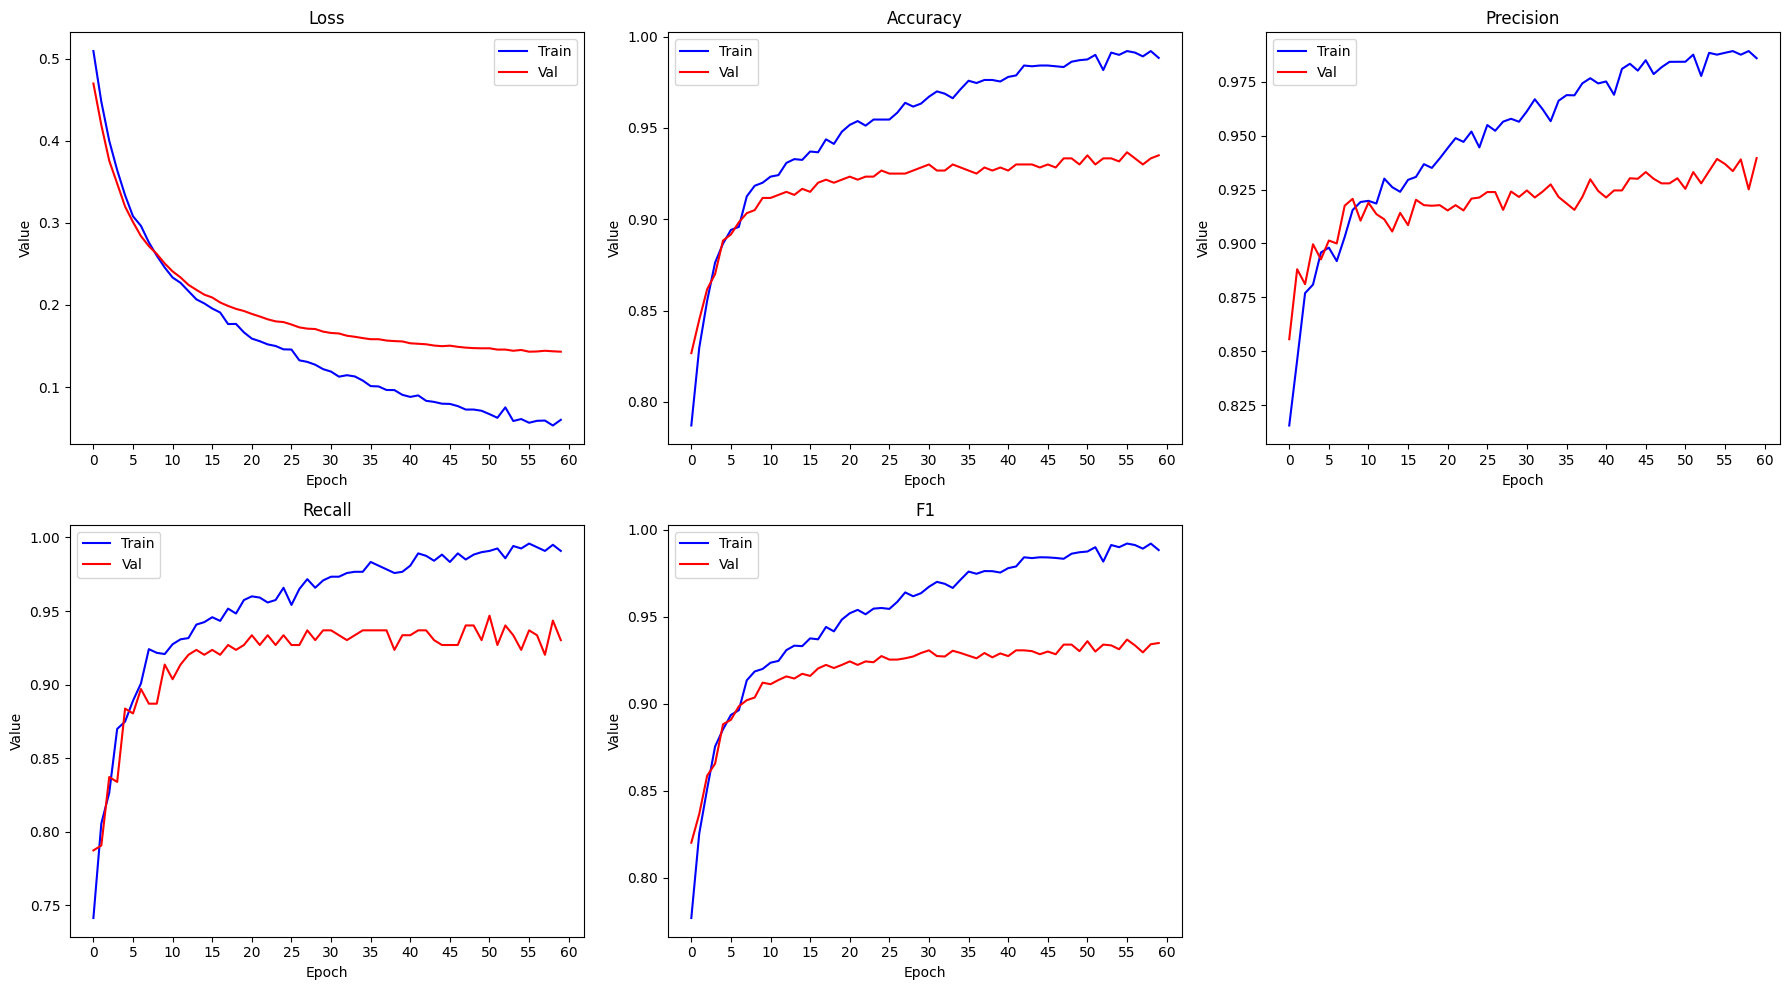

In [96]:
# Создание графиков
fig, axs = plt.subplots(2, 3, figsize=(18, 10), dpi=100)

axs[0, 0].plot(all_train_losses, label='Train', color='blue')
axs[0, 0].plot(all_val_losses, label='Val', color='red')
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Value')
axs[0, 0].xaxis.set_major_locator(plt.MultipleLocator(5))
axs[0, 0].legend()

axs[0, 1].plot(all_train_accuracy, label='Train', color='blue')
axs[0, 1].plot(all_val_accuracy, label='Val', color='red')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Value')
axs[0, 1].xaxis.set_major_locator(plt.MultipleLocator(5))
axs[0, 1].legend()

axs[0, 2].plot(all_train_precision, label='Train', color='blue')
axs[0, 2].plot(all_val_precision, label='Val', color='red')
axs[0, 2].set_title('Precision')
axs[0, 2].set_xlabel('Epoch')
axs[0, 2].set_ylabel('Value')
axs[0, 2].xaxis.set_major_locator(plt.MultipleLocator(5))
axs[0, 2].legend()

axs[1, 0].plot(all_train_recall, label='Train', color='blue')
axs[1, 0].plot(all_val_recall, label='Val', color='red')
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Value')
axs[1, 0].xaxis.set_major_locator(plt.MultipleLocator(5))
axs[1, 0].legend()

axs[1, 1].plot(all_train_f1, label='Train', color='blue')
axs[1, 1].plot(all_val_f1, label='Val', color='red')
axs[1, 1].set_title('F1')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Value')
axs[1, 1].xaxis.set_major_locator(plt.MultipleLocator(5))
axs[1, 1].legend()
    
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

# Тестирование

In [71]:
test_dataset = torchvision.datasets.ImageFolder(
  root='/kaggle/input/hotdognothotdog/hotdog-nothotdog/test',
  transform=val_transform  # transform для val подойдет и для test
)

# Создание DataLoader для test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
_, _, _, _, _ = val_test(test_loader)

Iteration_Test: 100%|███████████████████████████████████████████████| 11/11 [00:03<00:00,  3.08it/s]

Test:
 Loss: 0.14285760482942517
 F1: 0.9267515923566879, Accuracy: 0.9285714285714286, Precision:  0.9509803921568627, Recall: 0.9037267080745341


*Тестируем на рандомных картинках*

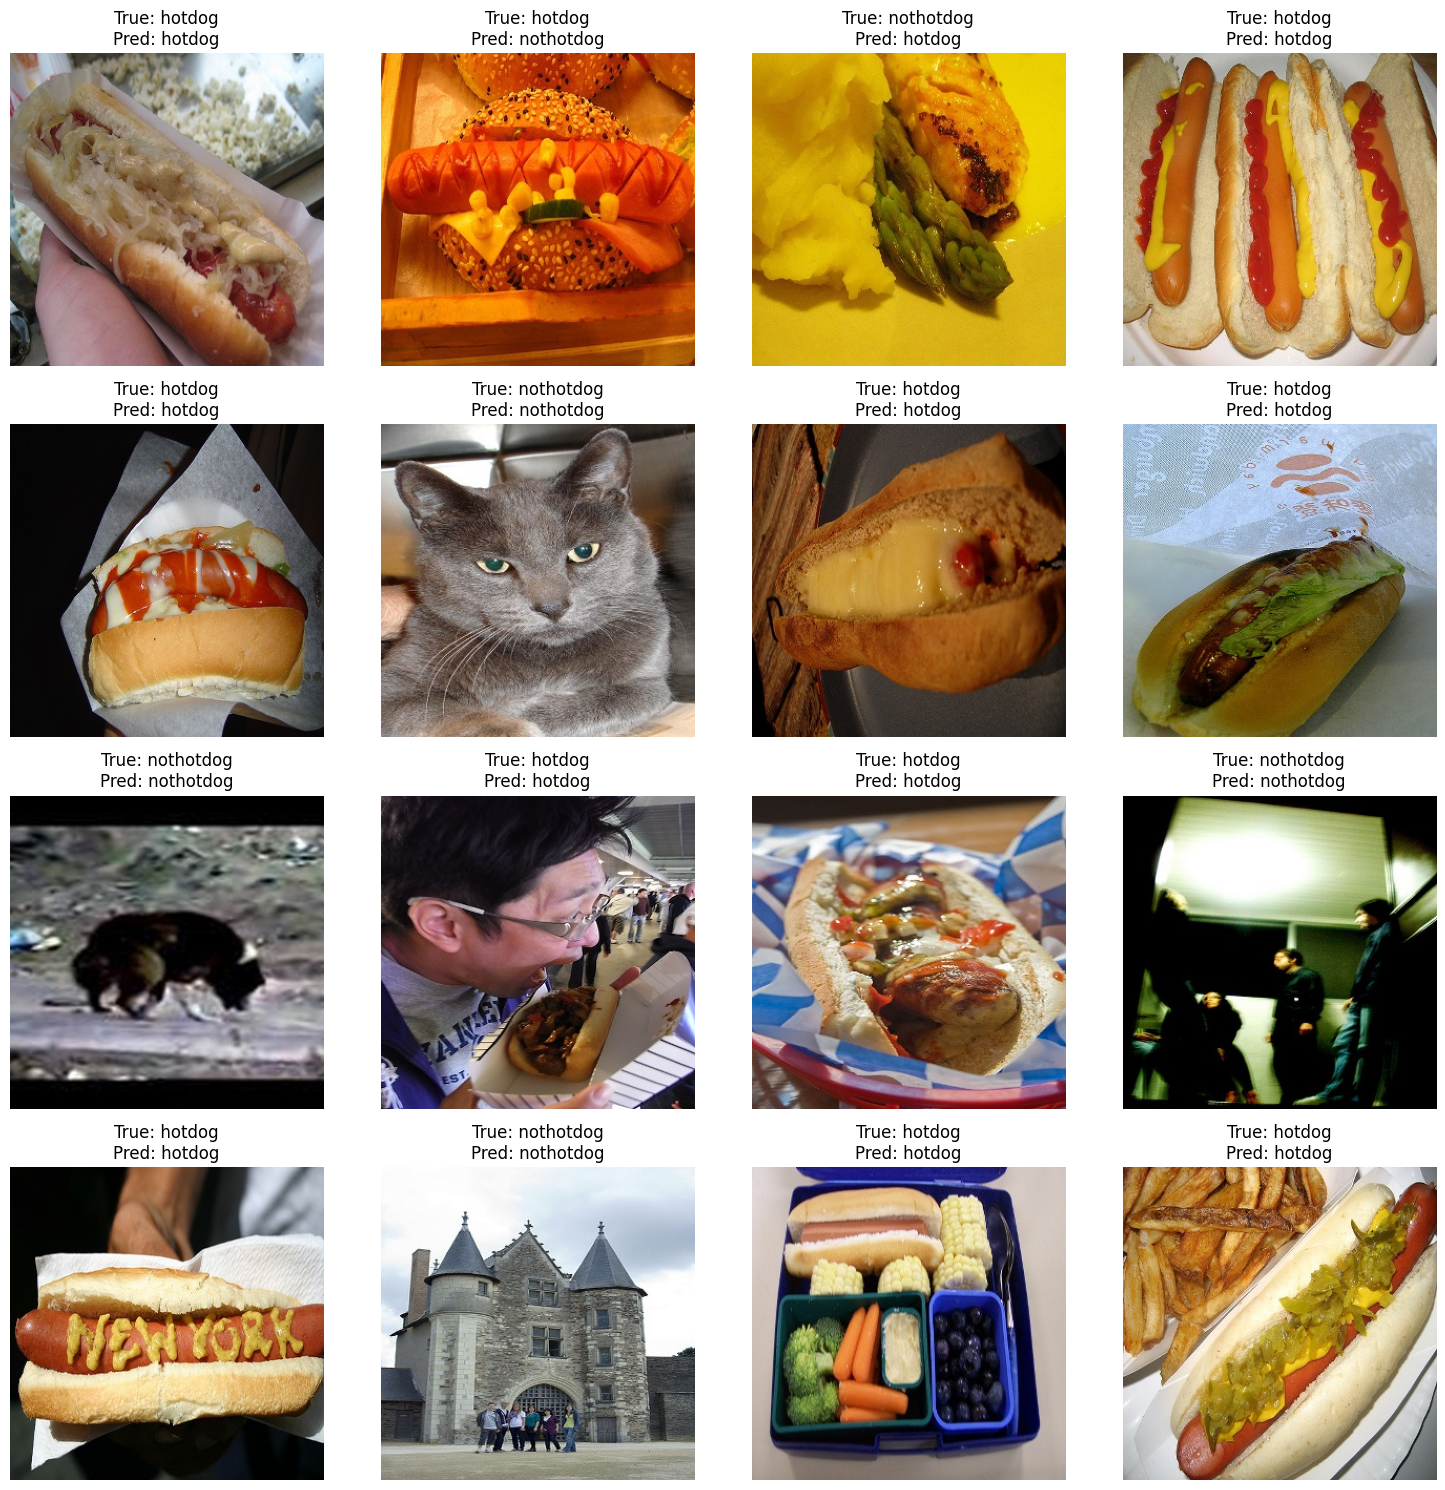

In [111]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnormalize = transforms.Compose([
    transforms.Normalize(mean = -mean / std, std = 1 / std)
])

def display_random_images(test_data_loader, model):
    # Set the model to evaluation mode
    model.eval()

    # Choose 16 random images from the dataloader
    num_images = 16
    rand_indices = torch.randperm(len(test_data_loader.dataset))[:num_images]

    # Set up the plot
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

    # Loop through the random images
    for i, idx in enumerate(rand_indices):
        # Get the image and its label
        image, label = test_data_loader.dataset[idx]

        # Send the image to the device used by the model
        img = image.to(next(model.parameters()).device)

        # Make a prediction on the image
        with torch.no_grad():
            output = model(img.unsqueeze(0))
            pred = output.argmax(dim=1)

        # Get the true label as a string
        true_label = test_data_loader.dataset.classes[label]

        # Get the predicted label as a string
        pred_label = test_data_loader.dataset.classes[pred.item()]

        # Выводим image, true label, и predicted label
        ax = axs[i // 4, i % 4]
        unnormalized_image = unnormalize(image)  # возвращаем цвет картинке
        rgb_image = unnormalized_image.permute(1, 2, 0)
        ax.imshow(rgb_image)
        ax.set_title(f'True: {true_label}\nPred: {pred_label}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


display_random_images(test_loader, model)